In [1]:
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
from math import sin, cos, sqrt, atan2, radians,log,log10

import json
from data import listedEiggHotels
from utils import *
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [5]:
# Merge anything within 30 m of each other
def cleanResidences(curr):
    curr = curr.keys()
    curr = list(map(lambda x: x.split(","),curr))
    curr = list(map(lambda x: [float(x[0]),float(x[1])], curr))
    new = []
    
    for k in curr:
        broken = False
        for item in new:
            d = seperationInMetres(k,item)
            if d < 30:
                broken = True
                break
        if not broken:
            new.append(k)
    
    return new

def seperationInMetres(p1,p2):
    R = 6373.0
    
    lat1,lon1 = p1
    lat2, lon2 = p2
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    #convert to metres
    return distance * 1000 


{0: Text(0.513257,-0.217944,'Tigh an Sithean – camping cabins & log cabins'),
 1: Text(-0.0814748,-0.237377,'Lageorna'),
 2: Text(0.55605,0.289523,'Tophouse'),
 3: Text(-0.60766,-0.655973,'Amazing Eigg Shed'),
 4: Text(0.293965,-0.192832,'Eigg Organics'),
 5: Text(0.288775,-1,'Kildonnan house'),
 6: Text(-0.893065,-0.279899,'Laig Caravan'),
 7: Text(-0.93084,-0.0384447,'Glebe Barn'),
 8: Text(-0.598386,0.754472,'The Smiddy'),
 9: Text(0.463361,0.0142936,"Sweeney's Bothy"),
 10: Text(0.909343,-0.644871,'Laig Beach Bothy'),
 11: Text(-0.702776,0.522342,'Eigg Camping Pods'),
 12: Text(0.162366,0.0972316,'Tigh Eilidh'),
 13: Text(0.810039,0.645663,'Eigg Eco Centre'),
 14: Text(-0.627861,0.104284,'Clanranald college'),
 15: Text(0.444907,0.839531,'Howlin Cottege')}

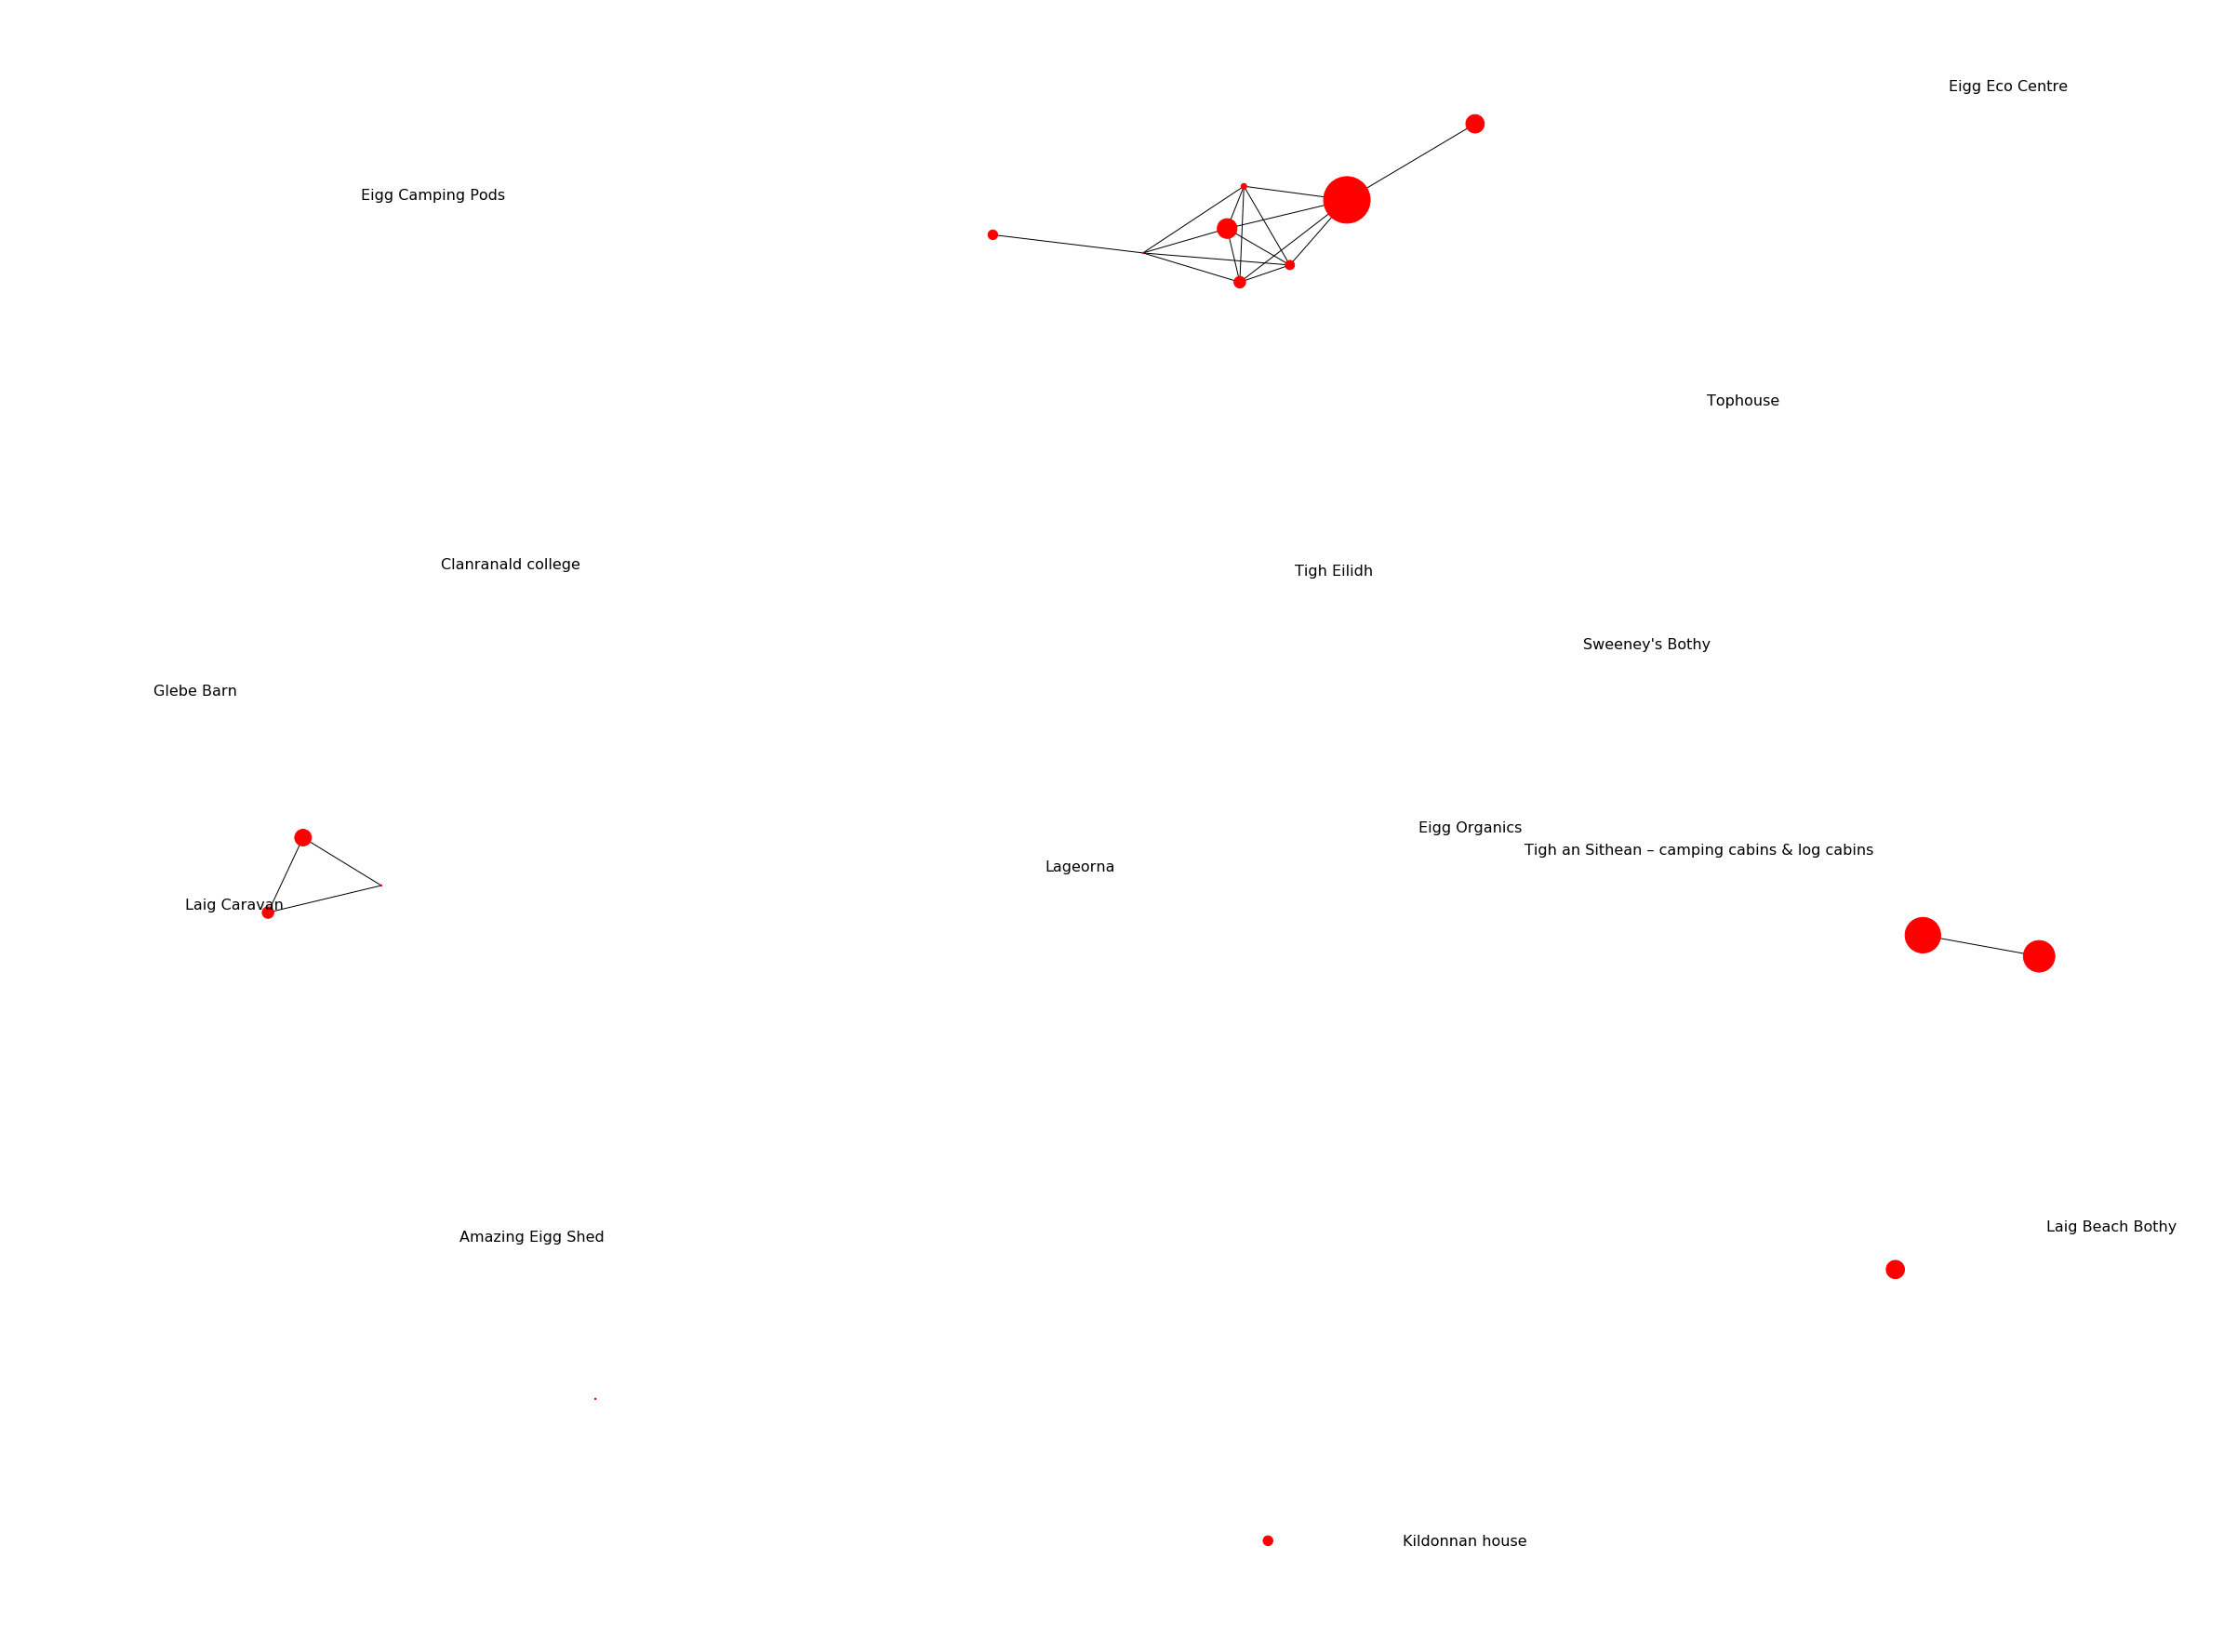

In [19]:
def listedEiggHotelRatings():
    hotelRatings = {}
    
    # *************  FORMAT  ***************
    # hotelRatings["NameOfHotel"] = [TripAdvisor/AirBnb Mean, Google Review Mean, FB likes]
    # =>  UNIQUE ID = [Populist rating, Accessibility rating, Popularity rating]
    
    #CAUTION ON SOCKPUPPETING
    
    hotelRatings["Tigh an Sithean – camping cabins & log cabins"] = [(3.75,4),(0,0),0]
    hotelRatings["Lageorna"] = [(4.87,75),(5,16),725]
    hotelRatings["Tophouse"] = [(0,0),(0,0),0]
    hotelRatings["Amazing Eigg Shed"] = [(4.91,105),(0,0),0]
    hotelRatings["Eigg Organics"] = [(1,1),(4.80,14),0]
    hotelRatings["Kildonnan house"] = [(4.89,36),(5,5),279]
    hotelRatings["Laig Caravan"] = [(4.9,39),(0,0),333]
    hotelRatings["Glebe Barn"] = [(4.84,45),(4.9,31),440]
    hotelRatings["The Smiddy"] = [(5,16),(4.5,2),0]
    hotelRatings["Sweeney's Bothy"] = [(5,57),(0,0),0]
    hotelRatings["Laig Beach Bothy"] = [(0,0),(0,0),0]
    hotelRatings["Eigg Camping Pods"] = [(0,0),(5,10),705]
    hotelRatings["Tigh Eilidh"] = [(5,16),(4,1),34]
    hotelRatings["Eigg Eco Centre"] = [(0,0),(5,3),0]
    hotelRatings["Clanranald college"] = [(0,0),(0,0),0]
    hotelRatings["Howlin Cottege"] = [(0,0),(5,2),0]
   
    return hotelRatings

def scoreIndividualHotelRating(rating, reviewMax, fbMax):
    tripAdvisor, googleReview, facebookLiked = rating
    
    tripAdvisorStars, numTripAdvisorRatings = tripAdvisor
    googleStars, numGoogleReviews = googleReview
    
    overallReviews = (numTripAdvisorRatings + numGoogleReviews) / reviewMax
    
    overallUserReview = 0
    
    if overallReviews != 0:
        overallUserReview = (numTripAdvisorRatings*tripAdvisorStars + numGoogleReviews*googleStars)/(overallReviews*reviewMax)
        
    fbReviews = facebookLiked / fbMax
    
    #print(1+(10**(0.2*overallUserReview + 0.6*overallReviews + 0.2*fbReviews)))
    return 1+(100**(0.2*overallUserReview + 0.6*overallReviews + 0.2*fbReviews))
    print(numTripAdvisorRatings,numGoogleReviews)
    return 10*(numTripAdvisorRatings+numGoogleReviews)+100

def mapHotelLocationToScore():
    hotelLocations = listedEiggHotels().keys()
    (rMax,fbMax) = gatherStatistics()
    hotelRatings = list(map(lambda x: scoreIndividualHotelRating(x, rMax,fbMax),listedEiggHotelRatings().values()))
    hotelWScore = list(zip(hotelLocations,hotelRatings))
    return hotelWScore

def gatherStatistics():
    ratings = listedEiggHotelRatings().values()
    reviewMax =  max([x[1][1]+x[0][1] for x in ratings])
    fbMax = max([x[2] for x in ratings])
    
    return reviewMax, fbMax

def buildGraph():
    scoredLocations = mapHotelLocationToScore()
    locs = list(map(lambda x: x[0],scoredLocations))
    locsT = toUsableLatLonList(locs)
    G = graphASetByObservations(locsT)
    scoredLocations = list(map(lambda x:x[1],scoredLocations))
    return G,scoredLocations,locs
 
G,scores,locsT = buildGraph()
pos=nx.spring_layout(G,k=1)
labs = {}
labels = list(map(lambda x: [x[0],listedEiggHotels()[locsT[x[0]]]],G.degree))
for k,v in labels:
    labs[k] = v
nx.draw(G, node_size = [s for s in scores])
nx.draw_networkx_labels(G,pos,labs,font_size=16)


In [ ]:
saveGraphToFile(G, "hotelsNoAttributes.txt")

In [ ]:
np.savetxt("hotelAttributes.txt",scores,delimiter=" ")

In [ ]:
usableSizes = list(map(lambda x: abs((log10(x)))/75,scores))
usableSizes

In [ ]:
dct = listedEiggHotels()
del dct['56.9017079,-6.1425028']
locs = toUsableLatLonList(dct.keys())
generateMapJSON([('fullColMarkers/marker76.png',locs,list(dct.values()),usableSizes)],[(locs,G)],'hotelsByRating.txt')

In [ ]:
toUsableLatLonList(dct.keys())

In [ ]:
len(listedEiggHotels().values()),len(scores)

In [ ]:
listedEiggHotels()